<a href="https://colab.research.google.com/github/chiconasa3000/learn_nlp/blob/main/sentiment_analysis_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

In [ ]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

<ipython-input-2-511d07bc3944>:2: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 74793 datasets available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
from datasets.load import load_dataset
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[2]

{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [ ]:
print(train_ds["label"][:5])

[0, 0, 3, 2, 3]


In [ ]:
print(train_ds.features["label"])

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)


# From Datasets to Dataframes

In [ ]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


-- using int2str method from class ClassLabel

In [ ]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### looking at the class distribution

In [ ]:
import matplotlib.pyplot as plt
def plot_target_frequencies(target):
  target.value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes")
  plt.show()

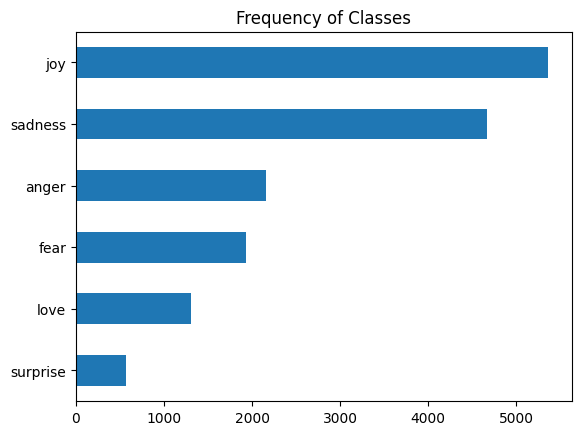

In [ ]:
plot_target_frequencies(df["label_name"])

#### Using sampling from imbalanced-learn library

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from collections import Counter
# get counter of training set
Counter(df["label"])

Counter({0: 4666, 3: 2159, 2: 1304, 5: 572, 4: 1937, 1: 5362})

In [ ]:
import math
equally_samp = math.floor(len(df["label"])/df["label"].nunique())
equally_samp

2666

In [ ]:
sampling_strategy = {
    0:500,
    1:500,
    2:500,
    3:500,
    4:500,
    5:500
}
sampling_strategy = "not minority"
#sampling_strategy = "not majority"
#sampling_strategy = sampling_strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(df["text"].array.reshape(-1,1), df["label"].array.reshape(-1,1))

In [ ]:
len(X_res)

3432

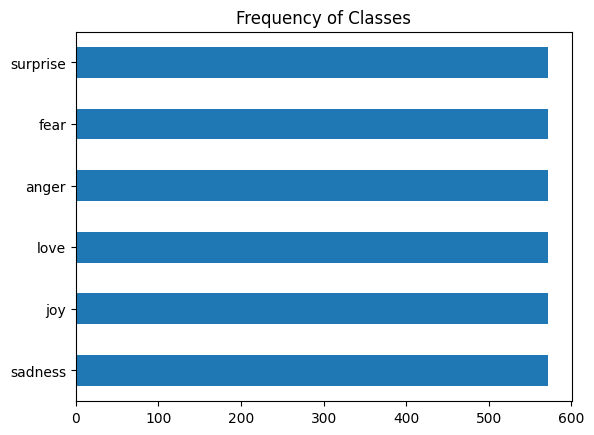

In [ ]:
new_emotions_df = pd.DataFrame(y_res,columns=["label"])
new_emotions_df["text"] = X_res
new_emotions_df["label_name"] = new_emotions_df["label"].apply(label_int2str)
new_emotions_df.head()
plot_target_frequencies(new_emotions_df["label_name"])

In [ ]:
#Counter({0: 4666, 3: 2159, 2: 1304, 5: 572, 4: 1937, 1: 5362})
Counter(new_emotions_df["label_name"])

Counter({'sadness': 572,
         'joy': 572,
         'love': 572,
         'anger': 572,
         'fear': 572,
         'surprise': 572})

In [ ]:
new_emotions_df.head()

,label,text,label_name
0,0,i feel like i am one of them now before i resi...,sadness
1,0,i used to feel sorry for some people who felt ...,sadness
2,0,i find myself chasing the needles and feeling ...,sadness
3,0,i still enjoy it because i do not feel like i ...,sadness
4,0,i am feeling pretty stinkin shitty for being s...,sadness


Text(0, 0.5, 'Counting')

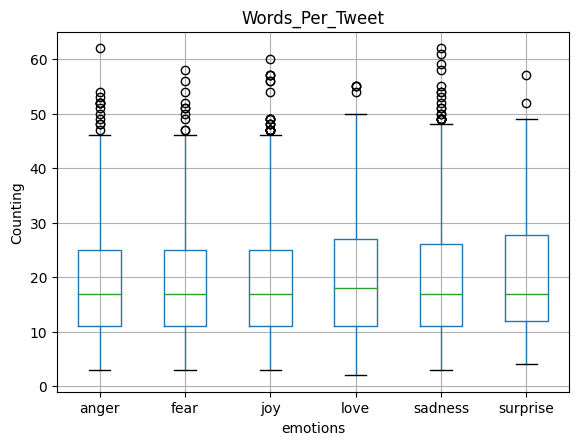

In [ ]:
# Counting Distribution
df["Words_Per_Tweet"] = new_emotions_df["text"].str.split().apply(len)
df.boxplot("Words_Per_Tweet", by="label_name")
plt.suptitle("")
plt.xlabel("emotions")
plt.ylabel("Counting")

In [ ]:
# Turn off Dataframe format from emotions
# deallocated dataframe emotions from memory
emotions.reset_format()

### Tokenization

#### Character Tokenization

In [ ]:
text = "I want to tokenize these words"
# cast to list the string in separable characters
tokenized_text = list(text)
print(tokenized_text)

['I', ' ', 'w', 'a', 'n', 't', ' ', 't', 'o', ' ', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'e', ' ', 't', 'h', 'e', 's', 'e', ' ', 'w', 'o', 'r', 'd', 's']


In [ ]:
# create a dictionary of character as key and number as value
# with tokenized text build a ordered set
token2idx = {ch:idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'I': 1, 'a': 2, 'd': 3, 'e': 4, 'h': 5, 'i': 6, 'k': 7, 'n': 8, 'o': 9, 'r': 10, 's': 11, 't': 12, 'w': 13, 'z': 14}


In [ ]:
# numericalization using the previous dictionary
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[1, 0, 13, 2, 8, 12, 0, 12, 9, 0, 12, 9, 7, 4, 8, 6, 14, 4, 0, 12, 5, 4, 11, 4, 0, 13, 9, 10, 3, 11]


In [ ]:
# example of encoding DragonBall characters
categorical_df = pd.DataFrame({"Name":["Goku", "Krilin","Vegeta"],"LabelId":[0,1,2]})
categorical_df

,Name,LabelId
0,Goku,0
1,Krilin,1
2,Vegeta,2


In [ ]:
pd.get_dummies(categorical_df["Name"])

,Goku,Krilin,Vegeta
0,1,0,0
1,0,1,0
2,0,0,1


#### Encoding OHE
- Parameters:
  - numericalizaction of characters (input_ids) as tensor
  - how many unique characters (len(token2idx))

In [ ]:
# text = "I want to tokenize these words"
import torch
import torch.nn.functional as F
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([30, 15])

In [ ]:
text = "I want to tokenize these words"

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot:{one_hot_encodings[0]}")

Token: I
Tensor index: 1
One-hot:tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['I', 'want', 'to', 'tokenize', 'these', 'words']


#### Subword Tokenization

In [ ]:
# import details about the chosen model
from transformers import AutoTokenizer, DistilBertTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
#specific
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)


#### Tokenizer with subwords
* functions
  - convert_ids_to_tokens
  - convert_tokens_to_string

In [ ]:
# encoding
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2215, 2000, 19204, 4697, 2122, 2616, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'want', 'to', 'token', '##ize', 'these', 'words', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i want to tokenize these words [SEP]


In [ ]:
# vocabulary size of tokenizer
# context sizer of the model
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"],padding=True, truncation=True)


In [ ]:
#cite from the book
# for each batch, the input sequences are padded to the maximum
# sequence length in the batch, the attention mask is used in the
# model to ignore the padded areas of the input vector

In [ ]:
# that sequence which has more tokens will be
#  the maximum sequence with more IDs so
# the rest with less will be pad

In [ ]:
# batch in one operation collect 2 or more sequences
# and get the ids and the mask in a matrix

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
# in one line tokenizer dataset
# DatasetDict has the "map" function
# this dataset has
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# now it jas input_ids and attention_mask
emotions_encoded["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

#### Using pretrained models
- Feature-based approach

In [ ]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
#nn.Module.to
model = AutoModel.from_pretrained(model_ckpt).to(device)

- Interoperability between frameworks

In [ ]:
from transformers import TFAutoModel
#loading in format of tensorflow
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


- using xlm-roberta which there is no version in TF but you could share from pytorch

In [ ]:
tf_xmlr = TFAutoModel.from_pretrained("xlm-roberta-base",from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [ ]:
# tokenizing in pytorch format tensor
text = ["this is a test","this is another test"]
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape:{inputs['input_ids'].size()}")

Input tensor shape:torch.Size([2, 6])


In [ ]:
# el shape is [#batch, #tokens]
# in other words [#length of sequences, #subwords]

In [ ]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102],
        [ 101, 2023, 2003, 2178, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])}

In [ ]:
# put encoding text in device
# put input_ids and attention_mask into device
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  # features from hidden layers
  outputs = model(**inputs)
print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]],

        [[-0.1162, -0.2141,  0.0413,  ..., -0.0686,  0.1630,  0.4792],
         [-0.3182, -0.7443, -0.0562,  ..., -0.1883,  0.4686,  0.3942],
         [-0.3632, -0.5047,  0.1790,  ..., -0.0075,  0.1189,  1.0068],
         [-0.1880, -0.4844,  0.1790,  ...,  0.1616,  0.4401,  0.3037],
         [ 0.1991, -0.4233, -0.3426,  ..., -0.2850,  0.0285, -0.3489],
         [ 1.0048,  0.0036, -0.4391,  ...,  0.1462, -0.6234, -0.2468]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
# the before only is computed one time
outputs.last_hidden_state.size()
# 6 tokens represented by 768 features
#[batch_size,n_tokens, hidden_dim]

torch.Size([2, 6, 768])

In [ ]:
# I think a set of sequences
# grouped by certain features are clustered
# this clustered have similar features
# in order to get these features the sequences
# should be partioned by tokens and feed the model by them
# as a vector with ids of every sequence
# at the final we have a pretrained model if we used it
# it returns the pretrained features from the token from
# the input sequence.

In [ ]:
# extract features from hidden_state
def extract_hidden_states(batch):
  #to gpu
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # get hidden state features for every sequence-token with all dims
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}

In [ ]:
# "torch" format
# pandas format is only to visualize a short samples of dataset
# working with emotions tokenizied
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask","label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

In [ ]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set
- using UMAP for dimension reduction
- MinMaxScaler to cast [0,1] interval features

In [ ]:
# "Uniform Manifold Approximation and Projection for Dimension Reduction"
!pip install umap-learn

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale feature to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
#Create a DataFrame of 2D embedings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.181736,6.126632,0
1,-3.205588,5.634735,0
2,5.036932,2.587944,3
3,-2.533336,3.740078,2
4,-3.584787,3.644556,3


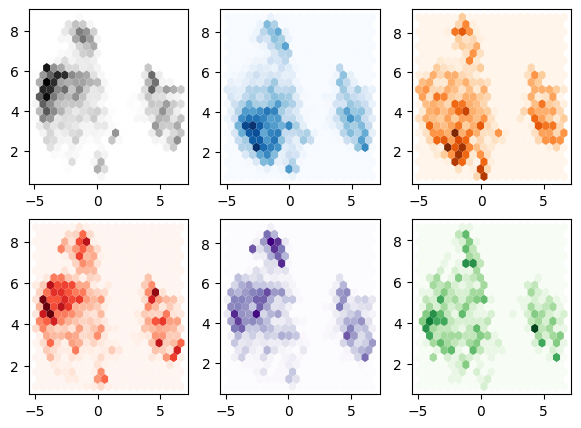

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(7,5))
# flatten to iterate with enumerate
axes = axes.flatten()
cmaps = ["Greys","Blues","Oranges","Reds","Purples","Greens"]
labels = emotions["train"].features["label"].names
for i, (label,cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))


### Training a simple classifier

In [ ]:
# from sklearn.linear_model import LogisticRegression

# lr_clf = LogisticRegression(max_iter=3000)
# lr_clf.fit(X_train, y_train)
# lr_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.dummy import DummyClassifier
# with a Dummy classifier
# it uses the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid,y_valid)

0.352

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

# y_preds = lr_clf.predict(X_valid)
# plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Tranformers

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels=6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# compute f1-score and accuracy
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install transformers[torch]

In [ ]:
# arguments to the model
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) //  batch_size
model_name = f"{model_ckpt}-finetuned_emotion"
training_args = TrainingArguments(
    output_dir = model_name,
    num_train_epochs = 2,
    learning_rate=2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    evaluation_strategy = "epoch",
    disable_tqdm = False,
    logging_steps = logging_steps,
    push_to_hub = True,
    log_level = "error"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    tokenizer = tokenizer
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.793200,0.297794,0.909500,0.909131
2,0.238800,0.209248,0.923000,0.923090


TrainOutput(global_step=500, training_loss=0.5160284271240234, metrics={'train_runtime': 248.1778, 'train_samples_per_second': 128.94, 'train_steps_per_second': 2.015, 'total_flos': 720342861696000.0, 'train_loss': 0.5160284271240234, 'epoch': 2.0})

In [ ]:
# predictions has predictions and metrics
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.20924793183803558,
 'test_accuracy': 0.923,
 'test_f1': 0.9230898241973974,
 'test_runtime': 4.316,
 'test_samples_per_second': 463.389,
 'test_steps_per_second': 7.414}

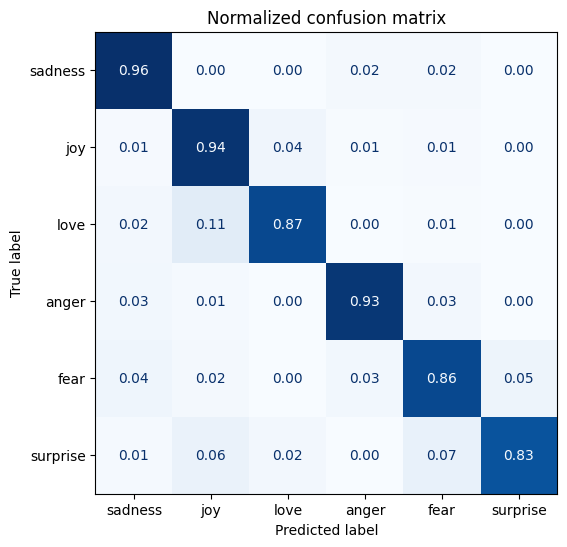

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine tuning with keras

In [ ]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))


In [ ]:
# cast to tensorflow datast
# inputs_ids and attention_mask
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols = ["label"],
    shuffle=True,
    batch_size = batch_size
)

tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols = ["label"],
    shuffle=False,
    batch_size = batch_size
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
import tensorflow as tf

tf_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset,epochs=2)

Epoch 1/2
250/250 [==============================] - 177s 553ms/step - loss: 0.5285 - sparse_categorical_accuracy: 0.8154 - val_loss: 0.1875 - val_sparse_categorical_accuracy: 0.9270
Epoch 2/2
250/250 [==============================] - 137s 546ms/step - loss: 0.1438 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.1443 - val_sparse_categorical_accuracy: 0.9380


### Error analysis

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  #prepare input
  # taking input_ids and attention mask to device
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    # compute loss between predictions and grount truth labels
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}



In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask","label"])
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label,
    batched=True,
    batch_size=16
)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label","loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.618810
1509,i guess this is a memoir so it feels like that...,joy,fear,5.278847
1963,i called myself pro life and voted for perry w...,joy,sadness,5.249996
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.199585
1801,i feel that he was being overshadowed by the s...,love,sadness,5.138009
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.094638
882,i feel badly about reneging on my commitment t...,love,sadness,4.937871
1274,i am going to several holiday parties and i ca...,joy,sadness,4.867008
1683,i had applied for a job and they had assured m...,anger,joy,4.685227
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.571399
